# Imports

In [1]:
from backend import (get_comparison_start_end_acts, get_conformance_stats,
                     get_dataframe, get_comparison_dfg, transform_dfg_to_pn)
import polars as pl
import pandas as pd
import pm4py

ERROR:root:backend.discover.animation: extend_polars.get_animation_data_rs not found.


In [2]:
from backend.conformance import PetriNet, Marking
import os

RESULT_FOLDER = './data/base'

def get_conformance_series(analysis_name: str, movimentos: pd.DataFrame,
                           petri_net: PetriNet, initial_mark: Marking,
                           final_mark: Marking) -> pd.DataFrame:
    file_path = f"{RESULT_FOLDER}/{analysis_name}.json"
    if os.path.exists(file_path):
        conformance_stats = pd.read_json(file_path, typ="series")
    else:
        conformance_stats = get_conformance_stats(movimentos, petri_net,
                                                  initial_mark, final_mark)
        conformance_stats.to_json(file_path, indent=2)
    return conformance_stats

In [3]:
def get_mm_avg_conformance(df_list: list[pl.DataFrame], percentage: float):
    """
    Get the merge miner comparison dfg, transforms to petri net and
    return the average of the conformance stats of all unidades
    """
    filter_count = len(df_list)
    comparison_dfg = get_comparison_dfg(df_list, percentage, filter_count)
    start_activities, end_activities = get_comparison_start_end_acts(
        df_list, percentage, filter_count)
    pm4py.view_dfg(comparison_dfg, start_activities, end_activities)

    start_activities = { x: 1 for x in start_activities }
    end_activities = { x: 1 for x in end_activities }
    pn, im, fm = transform_dfg_to_pn(comparison_dfg, start_activities,
                                     end_activities)

    conformance_stats: list[pd.DataFrame] = list()
    for i, df in enumerate(df_list):
        i += 1000
        df = df.to_pandas()
        name = f"mm_perc_{percentage}_df{i}"
        stats = get_conformance_series(name, df, pn, im, fm)
        conformance_stats.append(stats.to_dict())

    keys = set().union(*conformance_stats)
    return { key: sum(item.get(key, 0) for item in conformance_stats)
                / len(conformance_stats) for key in keys}

# Baseline

In [4]:
df_list = list()
for i in range(1000, 1008):
    df = get_dataframe(f"./datasets/movimentos_{i}.csv")
    df_list.append(df)

/root/JuMP-Research/merge_miner/backend/eventlog.py:52: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  dataframe = dataframe.with_columns([


## Threshold at 40%

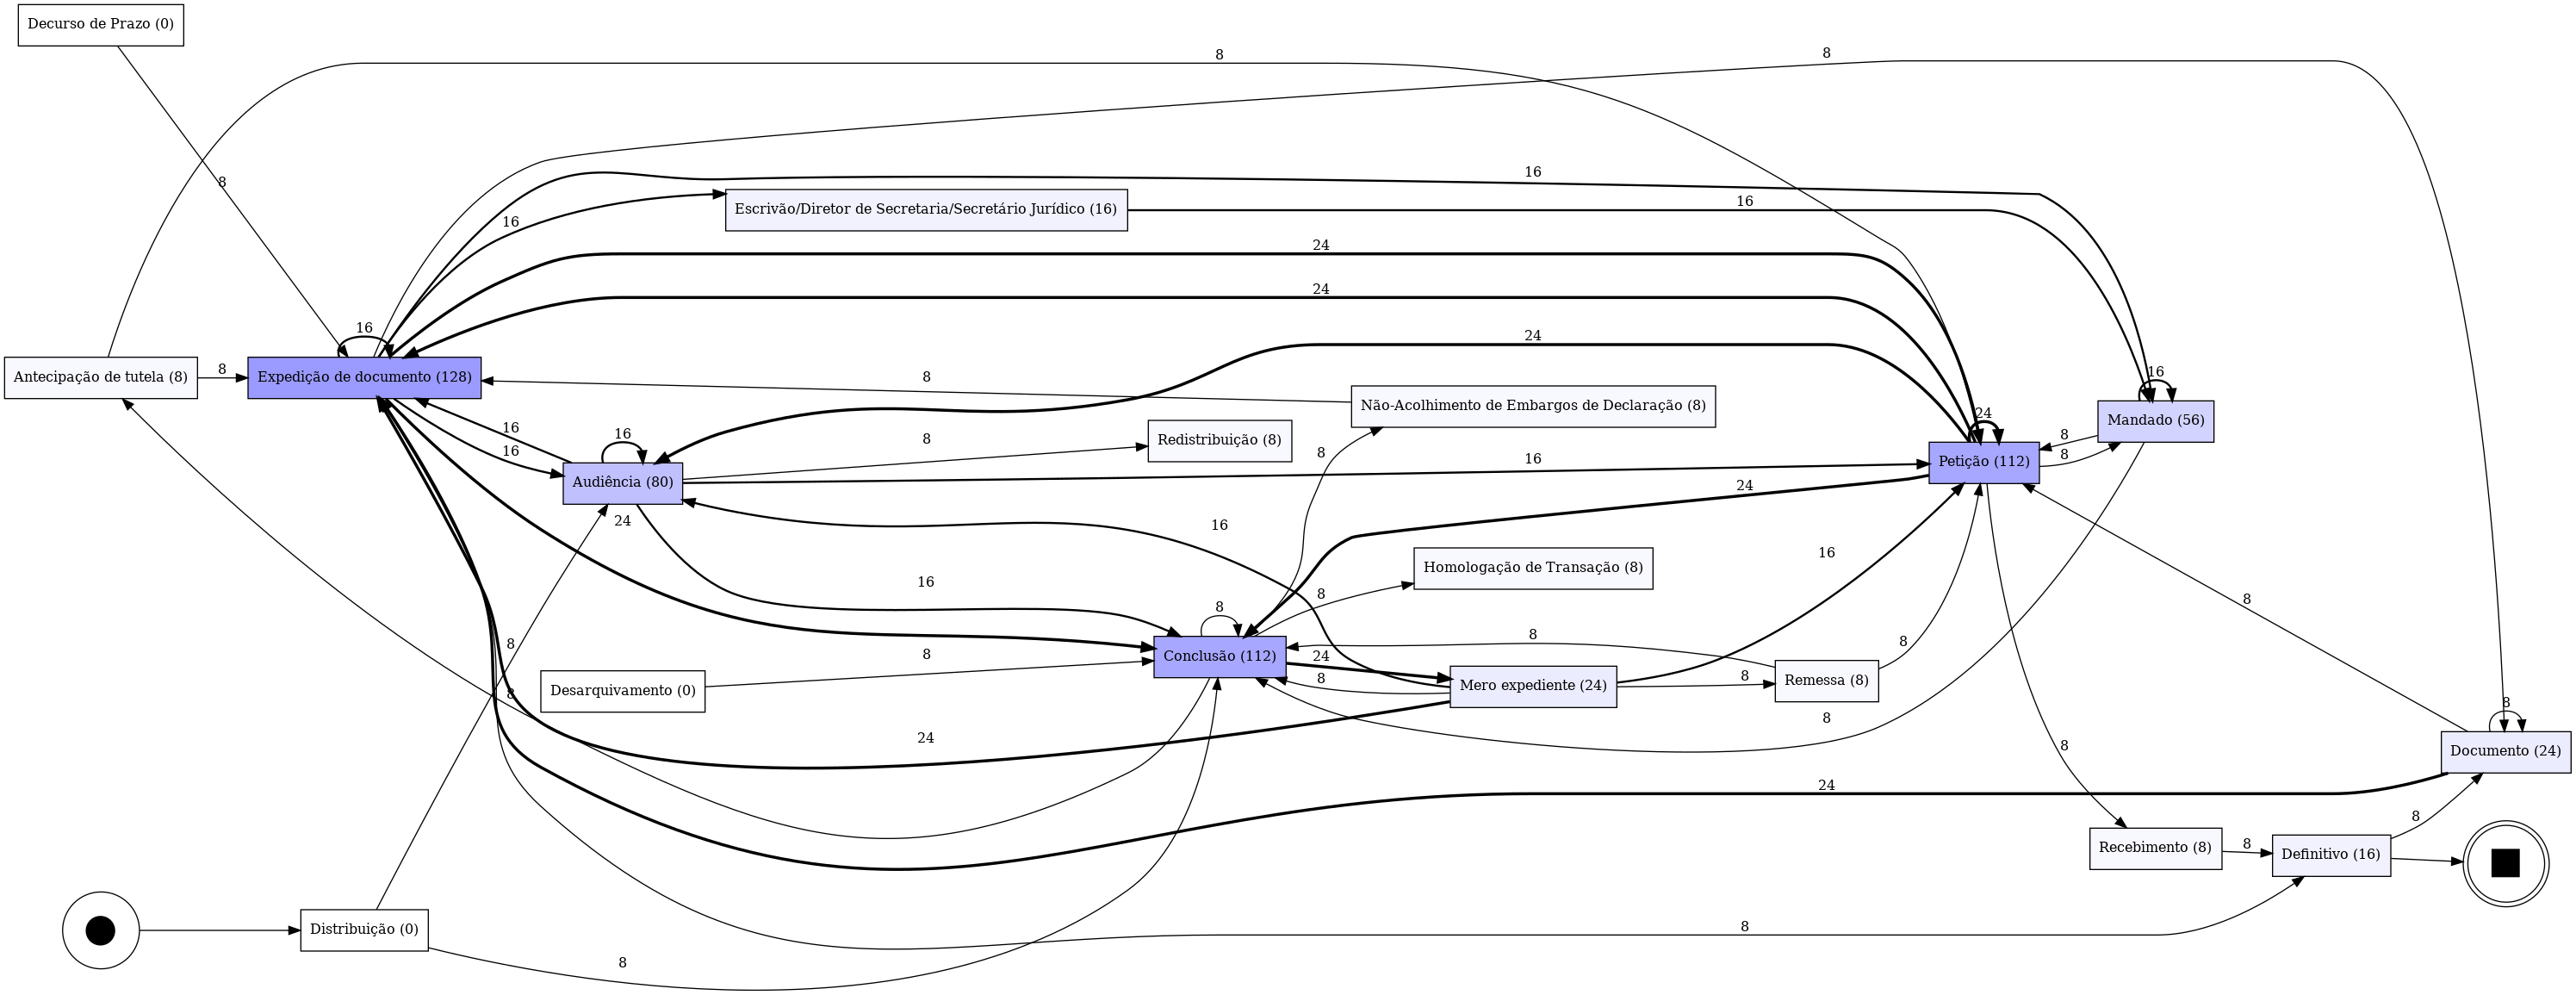

/root/JuMP-Research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
replaying log with TBR, completed traces :: 100%|██████████| 7843/7843 [01:33<00:00, 84.33it/s] 


,tbr_average_trace_fitness,f1_score,tbr_percentage_of_fitting_traces,tbr_precision,tbr_log_fitness,tbr_generalization
Results,0.945722,0.724778,5.606312,0.593467,0.949214,0.938641


In [5]:
avg_conformance_40 = get_mm_avg_conformance(df_list, 0.4)
pd.DataFrame(avg_conformance_40, index=["Results"])

## Threshold at 50% 

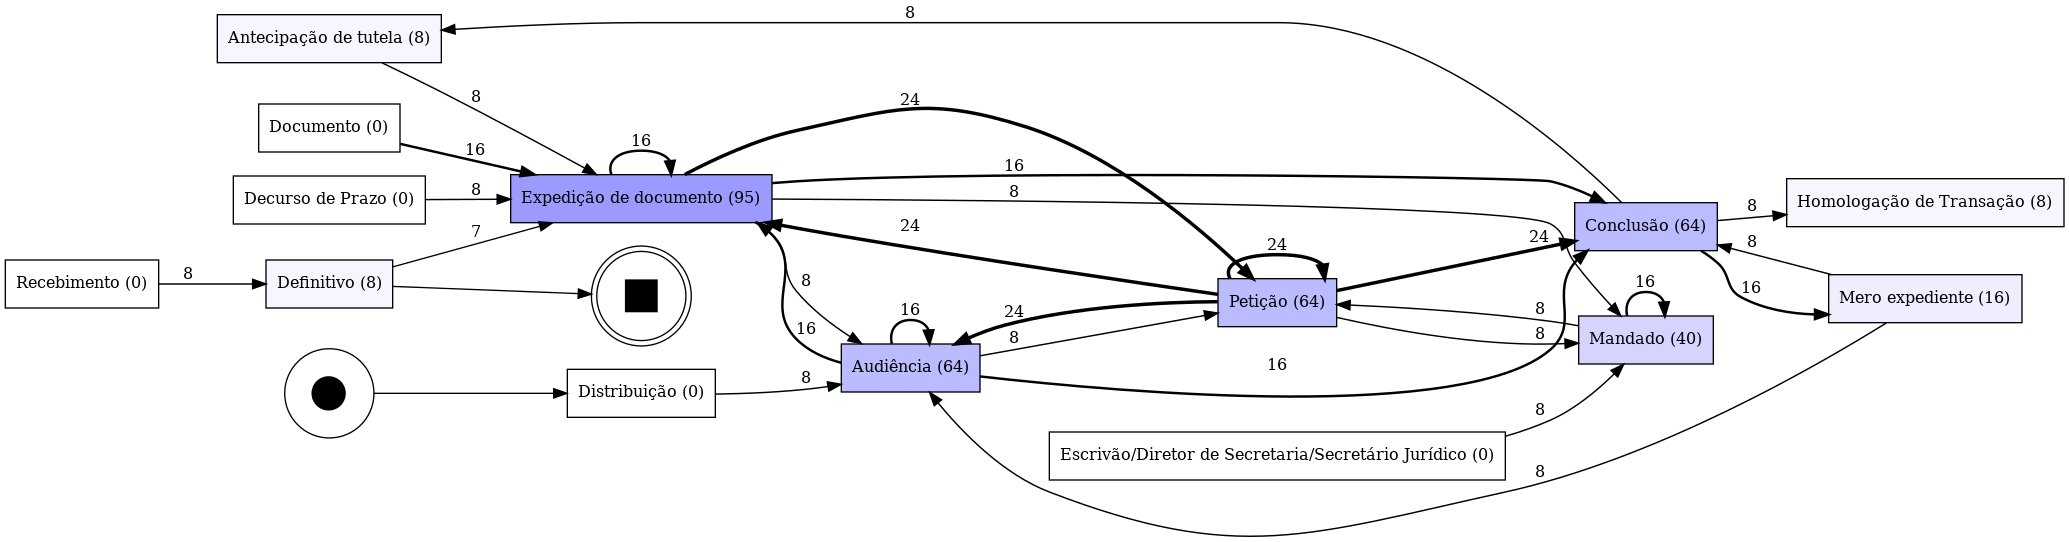

replaying log with TBR, completed traces :: 100%|██████████| 7843/7843 [01:16<00:00, 102.58it/s]


,tbr_average_trace_fitness,f1_score,tbr_percentage_of_fitting_traces,tbr_precision,tbr_log_fitness,tbr_generalization
Results,0.926181,0.80828,4.463595,0.728437,0.931,0.948706


In [6]:
avg_conformance_50 = get_mm_avg_conformance(df_list, 0.5)
pd.DataFrame(avg_conformance_50, index=["Results"])

## Threshold at 60%

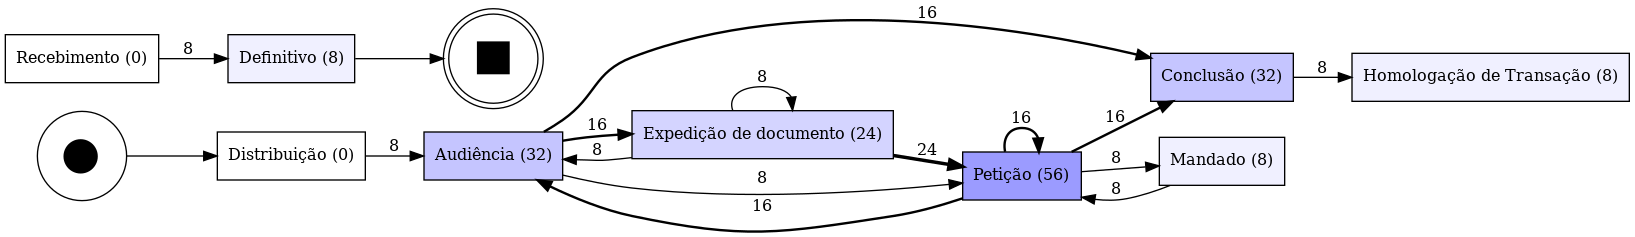

replaying log with TBR, completed traces :: 100%|██████████| 7843/7843 [00:55<00:00, 142.46it/s]


,tbr_average_trace_fitness,f1_score,tbr_percentage_of_fitting_traces,tbr_precision,tbr_log_fitness,tbr_generalization
Results,0.857704,0.880475,0.0,0.905088,0.853047,0.961745


In [7]:
avg_conformance_60 = get_mm_avg_conformance(df_list, 0.6)
pd.DataFrame(avg_conformance_60, index=["Results"])

# Threshold at 70%

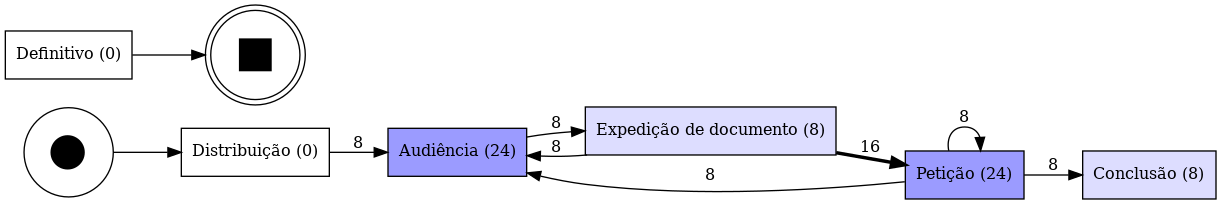

replaying log with TBR, completed traces :: 100%|██████████| 7843/7843 [00:45<00:00, 171.54it/s]


,tbr_average_trace_fitness,f1_score,tbr_percentage_of_fitting_traces,tbr_precision,tbr_log_fitness,tbr_generalization
Results,0.830217,0.89899,0.0,0.98227,0.830636,0.987719


In [8]:
avg_conformance_70 = get_mm_avg_conformance(df_list, 0.7)
pd.DataFrame(avg_conformance_70, index=["Results"])

In [13]:
pd.DataFrame([avg_conformance_40, avg_conformance_50, avg_conformance_60, avg_conformance_70])

,tbr_average_trace_fitness,f1_score,tbr_percentage_of_fitting_traces,tbr_precision,tbr_log_fitness,tbr_generalization
0,0.945722,0.724778,5.606312,0.593467,0.949214,0.938641
1,0.926181,0.808280,4.463595,0.728437,0.931000,0.948706
2,0.857704,0.880475,0.000000,0.905088,0.853047,0.961745
3,0.830217,0.898990,0.000000,0.982270,0.830636,0.987719
